# Questions
- 

In [134]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import math

# Methods

In [108]:
#src: https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/
def CountFrequency(my_list):
    # Creating an empty dictionary
    count = {}
    
    for i in my_list:
        count[i] = count.get(i, 0) + 1
    return count

In [69]:
def create_column_mapping(df, columns_text_list):
    ## returns: a dict with the keys = textual column labels
    ##     and values = raw data column labels 
    
    assert(type(df) == pd.core.frame.DataFrame)
    assert(type(columns_text_list) == list)
    
    raw_columns = pd.Index.tolist(df.columns)
    
    ## zip(keys, vals)
    return dict(zip(columns_text_list, raw_columns))
    
    

In [61]:
def clean_raw_data(df):
    ## returns: a dataframe containing only 
    ##      relevant rows from the raw data
    assert(type(df) == pd.core.frame.DataFrame)
    
    ## clean up extraneous top 5 rows
    data_temp0 = raw_data.iloc[5:df.index.size]
    ## every other row in the raw data is blank. clean that up
    data_temp = data_temp0.iloc[::2]
    return data_temp
    

In [166]:
def create_histogram(data, x_title, mapping, include_non_answers=False, cumulative=False):
    ## data -- clean data dataframe 
    ## x_title -- string
    ## include_non_answers -- boolean
    ## mapping -- the column mapping returned from create_column_mapping
    
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[mapping[x_title]])
    
    ## get number of bins for histogram
    num_bins = data_col.nunique()[0]
    
    if include_non_answers == True:
        num_bins = num_bins + 1
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
    
    #new_items = [x if !x.equals('nan') else '0' for x in items]

    
    # Matlab code: histogram(a.gender,'Normalization','probability','BarWidth',0.8);
    fig, ax = plt.subplots()
    
    # if cumulative set to true, do cumulative (i think it is???)
    if cumulative == True:
        n, bins, patches = ax.hist(flat_list, num_bins, density=1)
    else:
        n, bins, patches = ax.hist(flat_list, num_bins, weights=np.zeros_like(data_col) + 1. / data_col.size)
    
    ax.set_xlabel(x_title)
    plt.show()
    
    return n, bins, patches
    
    

# Main Code

In [11]:
## raw_data is of type(pandas.core.frame.DataFrame) -- 
## "DataFrame is a 2-dimensional labeled data structure 
## with columns of potentially different types. 
## You can think of it like a spreadsheet or SQL table, or a dict of Series objects."

## import the data file
raw_data = pd.read_csv('../Ethics_May+15,+2020_09.06_2.csv')

In [10]:
type(raw_data)

pandas.core.frame.DataFrame

In [45]:
## show more items when printing for debugging purposes
pd.options.display.max_seq_items = 2000
pd.options.display.max_columns = 2000

In [62]:
data = clean_raw_data(raw_data)

In [70]:
column_mapping = create_column_mapping(data,pd.Index.tolist(data.columns))

In [71]:
column_mapping['Gender'] = column_mapping.pop('I02')

In [76]:
## get the gender column
gender_col = pd.DataFrame(data, columns=[column_mapping['Gender']])

In [98]:
gender_col.nunique()[0]

2

In [79]:
gender_list = pd.Index.tolist(gender_col)

In [90]:
flat_list = [item for sublist in gender_list for item in sublist]

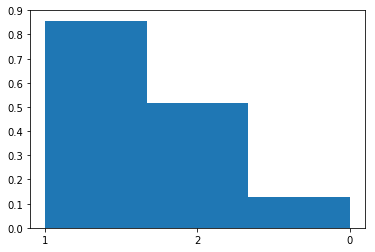

In [142]:
# histogram(a.gender,'Normalization','probability','BarWidth',0.8);
fig, ax = plt.subplots()
num_bins = 2
n, bins, patches = ax.hist(new_items, 3, density=1)
plt.show()

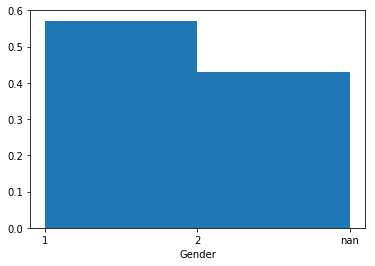

In [170]:
sauupa = create_histogram(data, 'Gender', column_mapping, False, True)

In [140]:
new_items = ['0' if type(x) == float and math.isnan(x) else x for x in flat_list]


In [141]:
new_items

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '1',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '2',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '2'

In [136]:
type(flat_list[583-9]) == float

True

In [114]:
print((333/583) + (201/583))

0.9159519725557461


In [112]:
print(201/583)

0.34476843910806176


In [72]:
column_mapping

{'StartDate': 'StartDate',
 'EndDate': 'EndDate',
 'Status': 'Status',
 'IPAddress': 'IPAddress',
 'Progress': 'Progress',
 'Duration (in seconds)': 'Duration (in seconds)',
 'Finished': 'Finished',
 'RecordedDate': 'RecordedDate',
 'ResponseId': 'ResponseId',
 'RecipientLastName': 'RecipientLastName',
 'RecipientFirstName': 'RecipientFirstName',
 'RecipientEmail': 'RecipientEmail',
 'ExternalReference': 'ExternalReference',
 'LocationLatitude': 'LocationLatitude',
 'LocationLongitude': 'LocationLongitude',
 'DistributionChannel': 'DistributionChannel',
 'UserLanguage': 'UserLanguage',
 'I03': 'I03',
 'I04': 'I04',
 'I05': 'I05',
 'I06': 'I06',
 'I07': 'I07',
 'C01': 'C01',
 'C02': 'C02',
 'C03': 'C03',
 'I08_1': 'I08_1',
 'I09_1': 'I09_1',
 'Q01_1': 'Q01_1',
 'T01_First Click': 'T01_First Click',
 'T01_Last Click': 'T01_Last Click',
 'T01_Page Submit': 'T01_Page Submit',
 'T01_Click Count': 'T01_Click Count',
 'Q02_1': 'Q02_1',
 'T02_First Click': 'T02_First Click',
 'T02_Last Click':

In [63]:
data

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,I02,I03,I04,I05,I06,I07,C01,C02,C03,I08_1,I09_1,Q01_1,T01_First Click,T01_Last Click,T01_Page Submit,T01_Click Count,Q02_1,T02_First Click,T02_Last Click,T02_Page Submit,T02_Click Count,Q03_1,T03_First Click,T03_Last Click,T03_Page Submit,T03_Click Count,Q04_1,T04_First Click,T04_Last Click,T04_Page Submit,T04_Click Count,Q05_1,T05_First Click,T05_Last Click,T05_Page Submit,T05_Click Count,Q06_1,T06_First Click,T06_Last Click,T06_Page Submit,T06_Click Count,Q07_1,T07_First Click,T07_Last Click,T07_Page Submit,T07_Click Count,Q08_1,T08_First Click,T08_Last Click,T08_Page Submit,T08_Click Count,Q09_1,T09_First Click,T09_Last Click,T09_Page Submit,T09_Click Count,Q10_1,T10_First Click,T10_Last Click,T10_Page Submit,T10_Click Count,Q11_1,T11_First Click,T11_Last Click,T11_Page Submit,T11_Click Count,Q12_1,T12_First Click,T12_Last Click,T12_Page Submit,T12_Click Count,Q13_1,T13_First Click,T13_Last Click,T13_Page Submit,T13_Click Count,Q14_1,T14_First Click,T14_Last Click,T14_Page Submit,T14_Click Count,Q15_1,T15_First Click,T15_Last Click,T15_Page Submit,T15_Click Count
5,1/15/2020 22:29,1/15/2020 22:32,1,NaN,100,174,1,1/15/2020 22:32,R_3lSU8xslPI30E61,NaN,NaN,NaN,NaN,41.85020447,-87.67359924,preview,EN,1,42,1,7,2,10,NaN,30,30,1,1,6,NaN,NaN,NaN,NaN,5,1.499,1.499,3.231,1,NaN,7.992,7.992,9.463,1,6,1.87,1.87,4.389,1,6,7.676,7.676,11.777,1,5,1.625,1.625,3.537,1,6,1.455,1.455,3.212,1,5,1.567,1.567,3.556,1,5,2.351,2.351,3.978,1,6,1.318,1.318,4.892,1,4,2.587,2.587,5.879,1,7,1.239,1.239,4.615,1,6,1.494,1.494,5.067,1,5,3.945,5.056,7.525,2,6,1.491,1.491,2.897,1
7,1/15/2020 23:06,1/15/2020 23:08,1,NaN,100,90,1,1/15/2020 23:08,R_3LYzJdXmTfxCq8e,NaN,NaN,NaN,NaN,41.85020447,-87.67359924,preview,EN,1,42,1,7,2,10,NaN,33,33,6,7,5,1.555,1.555,3.264,1,4,1.179,1.179,2.475,1,4,1.251,1.251,3.473,1,4,1.378,1.378,2.804,1,4,1.631,5.839,7.891,2,7,1.63,5.839,7.89,2,4,1.392,1.392,2.991,1,4,1.406,1.406,2.642,1,6,2.367,2.367,4.324,1,6,1.46,1.46,3.672,1,3,2.192,2.192,3.236,1,5,1.484,1.484,2.863,1,6,1.349,1.349,2.603,1,4,1.609,1.609,3.371,1,4,2.124,2.124,4.011,1
9,1/15/2020 23:26,1/15/2020 23:29,0,71.115.145.137,100,184,1,1/15/2020 23:29,R_20OmCwIT4hocybp,NaN,NaN,NaN,NaN,43.15710449,-76.32800293,anonymous,EN,1,29,1,6,1,6,NaN,1,1,5,2,6,4.274,4.274,4.844,1,1,6.979,6.979,8.307,1,2,1.358,6.218,7.065,3,1,2.411,3.552,4.426,2,7,0.903,8.109,8.349,5,7,2.377,2.377,4.944,1,3,1.493,5.334,7.346,2,7,3.966,5.493,5.779,3,5,2.934,4.326,5.157,2,7,8.028,8.028,8.485,1,5,7.72,9.114,9.35,3,6,4.583,4.583,7.166,1,2,2.236,2.236,3.735,1,2,1.739,13.28,13.842,4,3,12.119,16.377,17.335,2
11,1/15/2020 23:32,1/15/2020 23:38,0,73.189.183.209,100,369,1,1/15/2020 23:38,R_1JPbyVnDNWKfrtU,NaN,NaN,NaN,NaN,37.31770325,-121.9380035,anonymous,EN,1,36,18,6,1,10,NaN,1,1,1,1,2,17.032,17.976,19.961,2,7,9.449,9.978,11.612,2,1,19.879,19.879,20.891,1,4,21.448,21.448,22.378,1,7,10.22,10.22,13.747,1,7,4.579,5.024,5.614,2,7,8.25,8.25,10.867,1,3,10.466,11.77,12.625,3,1,26.885,27.49,29.321,2,1,8.01,9.935,11.241,2,6,9.093,15.019,15.765,3,1,1.834,16.818,18.618,2,1,5.159,5.813,7.208,2,7,6.382,6.382,8.206,1,1,24.4,24.4,25.784,1
13,1/15/2020 23:32,1/15/2020 23:39,0,73.48.80.170,100,418,1,1/15/2020 23:39,R_eL0qVRF5vPDTDG1,NaN,NaN,NaN,NaN,30.49079895,-84.31580353,anonymous,EN,1,37,1,6,1,5,NaN,2,2,1,1,2,3.114,23.757,24.602,3,3,8.802,8.802,11.792,1,5,11.416,11.416,12.51,1,1,14.872,14.872,15.88,1,5,13.26,13.26,14.003,1,7,28.986,28.986,30.3,1,5,20.477,20.477,21.915,1,3,16.626,16.626,17.37,1,5,15.236,15.236,16.154,1,6,17.706,17.706,19.181,1,6,4.006,21.198,22.131,3,5,1.996,48.752,50.4,4,3,20.241,20.241,21.366,1,1,5.581,5.581,6.43,1,1,12.025,14.485,15.364,2
15,1/16/2020 9:27,1/16/2020 9:35,0,98.232.238.129,100,524,1,1/16/2020 9:35,R_1OwyMPKAabytKRM,NaN,NaN,NaN,NaN,44.59280396,-123.2745972,anony

In [43]:
pd.DataFrame(data_temp, columns=['Gender'])

,Gender
5,NaN
7,NaN
9,NaN
11,NaN
13,NaN
15,NaN
17,NaN
19,NaN
21,NaN
23,NaN
